In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scripts.python.tsa.ts_utils import *
from statsmodels.tsa.api import VAR

In [2]:
folderpath = os.getcwd() + "/data/text/solomon_islands/"
nlp = spacy.load("en_core_web_sm")

def process_data(filename, folderpath=folderpath):
    df = pd.read_csv(folderpath + filename).drop("Unnamed: 0", axis=1)
    df["news"] = df["news"].replace("\n", "")
    df["date"] = pd.to_datetime(df["date"])
    df["ym"] = [str(d.year) + "-" + str(d.month) for d in df.date]
    return df


def get_news_count(data: pd.DataFrame, column: str):
    count_df = (data.set_index("date").groupby("ym")[[
        str(column)
    ]].count().reset_index().rename({str(column): str(column) + "_count"},
                                    axis=1))
    return count_df


def check_epu_category(row, terms):
    return any([word in str(row) for word in terms])


def get_epu_zscore(data: pd.DataFrame, 
                   cutoff_index: int,
                   epu_col: str = "epu_count",
                   news_col: str = "news_count") -> pd.Series:
    ratio = data[epu_col] / data[news_col]
    ratio_t1 = ratio[:cutoff_index]
    mean, std = ratio_t1.mean(), ratio_t1.std()
    z_score = abs(ratio - mean) / std
    return z_score

In [3]:
ss = process_data("solomon_stars_news.csv")
st = process_data("solomon_times_news.csv")
tis = process_data("island_sun_news.csv")
sibc = process_data("sibc_news.csv")

In [4]:
def extract_entities(corpus: str):
    doc = nlp(corpus)
    ner_dict = {"LOC": "", "ORG": "", "GPE": "", "WORK_OF_ART": ""}
    for e in doc.ents:
        if e.label_ in ner_dict.keys() and e.text not in ner_dict[e.label_]:
            ner_dict[e.label_] += e.text + ", "

    for key, val in ner_dict.items():
        if val.endswith(", "):
            ner_dict[key] = val[:-2]
    return ner_dict

In [5]:
from tqdm import tqdm
for data, name in zip([st], ["solomon_times_ner"]):
    output = []
    with tqdm(total=len(data)) as pbar:
        for news in data["news"]:
            if type(news) == str:
                ner_dict = extract_entities(news)
            else:
                ner_dict = {
                    "LOC": "Missing",
                    "ORG": "Missing",
                    "GPE": "Missing",
                    "WORK_OF_ART": "Missing"
                }
            output.append(ner_dict)
            pbar.update(1)
    ner_df = pd.DataFrame(output)
    data = pd.concat([data, output], axis=1)
#     data.to_csv(folderpath+name+".csv", encoding="utf-8")

  1%|▉                                                                           | 128/11049 [00:03<05:13, 34.84it/s]


KeyboardInterrupt: 

In [6]:
econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "financial", "industry", "food"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risky", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]

solomon_lst = [
    "solomon", "solomon islands", "honiara", "central province", "tulagi",
    "choiseul", "taro", "guadalcanal", "isabel province", "buala",
    "malaita", "auki", "kirakira", "makira-ulawa", "makira ulawa",
    "rennell and bellona", "tigoa", "temotu", "lata", "western province",
    "gizo"
]


In [7]:
mindate = min(st.date.min(), ss.date.min(), tis.date.min())
maxdate = max(st.date.max(), st.date.max(),  tis.date.max())
start = str(mindate.year) + "-" + str(mindate.month)
end = str(maxdate.year) + "-" + str(maxdate.month)

In [8]:
stats = pd.DataFrame(pd.date_range(start, end, freq="MS"), columns=["date"])
for nps, np_name in zip([st, ss, tis, sibc], ["st", "ss", "tis", "sibc"]):
    nps["news"] = nps["news"].str.lower()
    np_count = get_news_count(nps, "news")
    for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                    [econ_lst, uncertain_lst, policy_lst]):
        if np_name != "ss":
            nps["solomon"] = nps["news"].apply(check_epu_category,
                                             terms=solomon_lst)
        else:
            nps["solomon"] = True
        
        nps[str(category)] = nps["news"].apply(check_epu_category,
                                             terms=term_lst)
    nps["epu"] = ((nps.econ == True) & (nps.uncertain == True) &
                 (nps.policy == True) & (nps.solomon == True))
    np_epu_count = get_news_count(nps[nps.epu == True], column="epu")
    np_stat = np_count.merge(np_epu_count, how="left").fillna(0)
    np_stat["date"] = pd.to_datetime(np_stat["ym"])
    cutoff_index = np_stat[np_stat.date == "2019-12"].index[0] + 1
    np_stat["z_score"] = get_epu_zscore(np_stat, cutoff_index)
    np_stat.columns = [
        str(np_name) + "_" + str(col) if col != "date" and col != "ym" else col
        for col in np_stat.columns
    ]
    stats = (stats.merge(np_stat, how="left",
                         on="date")).drop("ym", axis=1).fillna(0)

In [9]:
select_cols = [col for col in stats.columns if "z_score" in col]
scaling_factor = 100/(stats[stats.date >= "2020-01-01"][select_cols].mean(axis=1).mean())
stats["z_score"] = stats[select_cols].mean(axis=1)
stats["epu_index"] = stats["z_score"] * scaling_factor

## EPU -> Macroeconomic

In [9]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.0,
    103.8, 104.1, 104.2, 104.5, 103.8, 105.1, 104.2, 104.2, 104.3, 105.0,
    108.0, 105.5, 106.6, 106.9, 106.9, 112.4, 112.7, 112.7, 112.2, 111.1,
    107.2, 105.8, 105.1, 105.4, 105.2, 105.3, 104.1, 106.7, 110.6, 112.4,
    109.8, 109.2, 106.6, 106.1, 106.6, 107.3, 107.5, 107.4, 107.8, 108.8,
    109.4, 109.4, 111.5, 113.9, 114.1, 115.4, 117.1, 118.0, 117.8, 117.2,
    117.0, 118.9, 119.2, 119.8
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-03", freq="MS"), columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(stats[["date", "epu_index"]], how="left", on="date")
si_infl["inflation"] = (si_infl["cpi"].diff()/si_infl["cpi"].shift(1)) * 100
si_infl["epu_change"] = (si_infl["epu_index"].diff() /
                         si_infl["epu_index"].shift(1)) * 100

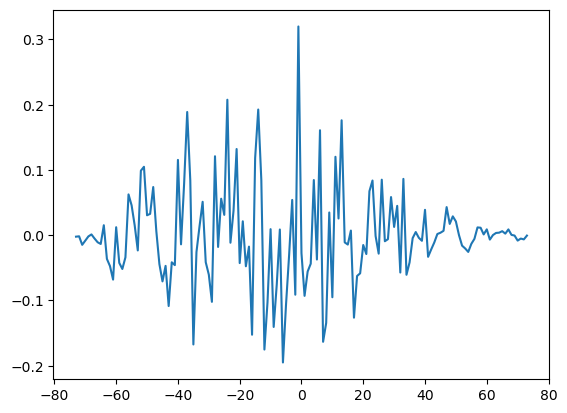

In [11]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - p.mean()) / (p.std() * len(p))
    q = (q - q.mean()) / (q.std())
    c = np.correlate(p, q, 'full')
    return c


corr = ccf_values(si_infl["epu_index"][1:], si_infl["inflation"][1:])
lags = signal.correlation_lags(len(si_infl["inflation"][1:]),
                               len(si_infl["epu_index"][1:]))
plt.plot(lags, corr);

In [12]:
ccf_df = pd.DataFrame([lags, corr], index=["lags", "ccf"]).T
ccf_df[(ccf_df.lags >= -3) & (ccf_df.lags <= 6)]

,lags,ccf
70,-3.0,0.054080
71,-2.0,-0.091193
72,-1.0,0.319960
73,0.0,-0.027509
74,1.0,-0.092961
75,2.0,-0.055663
76,3.0,-0.043655
77,4.0,0.084574
78,5.0,-0.037249
79,6.0,0.160906


In [13]:
var_df = si_infl[["inflation", "epu_index"]][1:].reset_index(drop=True)
print(adf_test(var_df["epu_index"]), "\n", adf_test(var_df["inflation"]))

Test Statistic                -9.021400e+00
p-value                        5.762258e-15
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64 
 Test Statistic                -6.971426e+00
p-value                        8.644916e-10
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64


In [14]:
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]

    def adjust(val, length=6):
        return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">",
              adjust(cvt, 8), ' =>  ', trace > cvt)


cointegration_test(si_infl[["inflation", "epu_index"]].iloc[
    1:,
])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
inflation ::  16.06     > 12.3212   =>   True
epu_index ::  1.2       > 4.1296    =>   False


In [15]:
length = len(si_infl.iloc[1:])
train = int(length * 0.9)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,9.805674,10.004733,18138.630383,9.884332
1,2,9.881134,10.215655,19569.805711,10.013124
2,3,10.010146,10.482401,22290.211200,10.196191
3,4,10.005401,10.617725,22233.085776,10.246231
4,5,10.104326,10.859116,24634.831732,10.400676
5,6,10.182071,11.081788,26778.109669,10.534678
6,7,10.206808,11.253980,27679.830094,10.616415
7,8,10.306809,11.504034,30958.238883,10.774158
8,9,10.415407,11.765352,35085.730392,10.941238
9,10,10.541341,12.046747,40702.167664,11.126393


In [16]:
best_mod = model.fit(1)
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Sep, 2023
Time:                     16:07:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.0047
Nobs:                     66.0000    HQIC:                   9.88433
Log likelihood:          -504.887    FPE:                    18138.6
AIC:                      9.80567    Det(Omega_mle):         16595.6
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.259349         0.227167           -1.142           0.254
L1.inflation         0.195267         0.116873            1.671           0.095
L1.epu_index         0.004470         0.001535            2.

In [17]:
si_infl["epu_change_1"] = si_infl["epu_change"].shift(1)
si_infl["epu_change_2"] = si_infl["epu_change"].shift(2)
si_infl

,date,cpi,epu_index,inflation,epu_change,epu_change_1,epu_change_2
0,2017-01-01,98.6,27.257114,NaN,NaN,NaN,NaN
1,2017-02-01,99.0,12.898663,0.405680,-52.677809,NaN,NaN
2,2017-03-01,100.6,27.257114,1.616162,111.317351,-52.677809,NaN
3,2017-04-01,100.7,27.257114,0.099404,0.000000,111.317351,-52.677809
4,2017-05-01,101.0,27.257114,0.297915,0.000000,0.000000,111.317351
...,...,...,...,...,...,...,...
70,2022-11-01,117.2,74.146784,-0.509338,-30.521654,112.937717,-22.245716
71,2022-12-01,117.0,74.146784,-0.170648,0.000000,-30.521654,112.937717
72,2023-01-01,118.9,44.235094,1.623932,-40.341183,0.000000,-30.521654
73,2023-02-01,119.2,67.197958,0.252313,51.910964,-40.341183,0.000000


In [18]:
import statsmodels.formula.api as smf
ols_mod = smf.ols("inflation~epu_change_1", data=si_infl[:train+1])
ols_res = ols_mod.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     5.169
Date:                Mon, 11 Sep 2023   Prob (F-statistic):             0.0264
Time:                        16:08:01   Log-Likelihood:                -108.59
No. Observations:                  65   AIC:                             221.2
Df Residuals:                      63   BIC:                             225.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1340      0.169      0.792      0.431      -0.204       0.472
epu_change_1     0.0021      0.001      2.273      0.026       0.000       0.004
==============================================================================
Omnibus:                        4.718   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                5.025
Skew:                           0.254   Prob(JB):                       0.0811
Kurtosis:                       4.264   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
ols_predict = ols_res.fittedvalues
ols_forecast = ols_res.predict(si_infl["epu_change_1"][-test:])
ols_all = pd.concat([ols_predict, ols_forecast], axis=0)

In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([1.87670199, 2.00587147])

In [21]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])

In [22]:
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df["inflation"] = var_df["inflation"][:train+1]
fit_df

,var_inflation,var_epu_index,inflation
1,-0.122479,113.201728,1.616162
2,0.178068,103.597059,0.099404
3,-0.118105,114.215800,0.297915
4,-0.079343,112.826035,-0.396040
5,-0.272504,118.699620,-0.099404
...,...,...,...
62,0.511572,103.481791,1.919561
63,0.551307,95.943773,2.152466
64,0.557464,95.005629,0.175593
65,0.064494,110.728955,1.139351


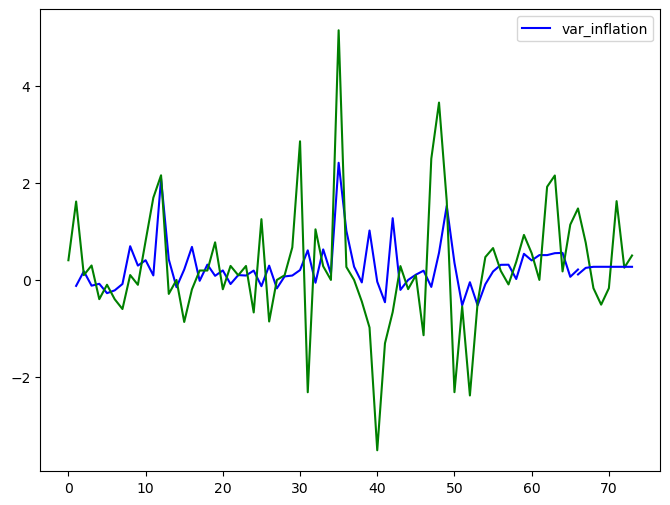

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
fit_df[["var_inflation"]].plot(ax=ax, color="blue")
ax.plot(var_df["inflation"], color="green")
ax.plot(var_forecast_df["var_inflation"].index.values,
        var_forecast_df["var_inflation"].values,
        label="var_predict_test", color="blue")
# ax.plot(ols_all, color="orange")
plt.show();

## EPU

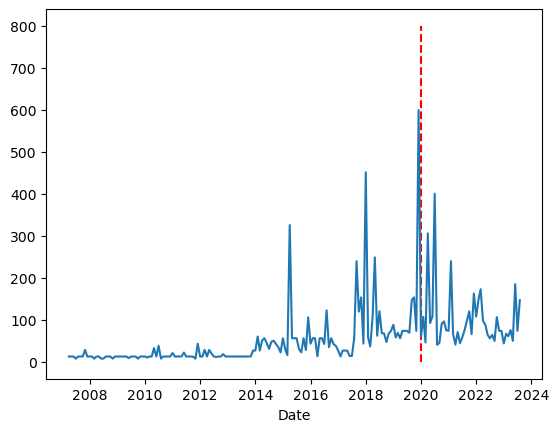

In [10]:
plt.plot(stats["date"].values, stats["epu_index"].values, label="EPU Index")
plt.xlabel("Date")
plt.vlines(x=pd.to_datetime("2020-01-01"), ymin=0, ymax=800, color="red", linestyle="dashed")
# plt.hlines(y=100, xmin=pd.to_datetime("2007-01"), xmax=pd.to_datetime("2024-01"), color="green", linestyle="dashed")
plt.show()

In [11]:
ss[(ss.date>="2015-12-01") & (ss.date <= "2015-12-31") & (ss.epu == True)].url.tolist()

['https://www.solomonstarnews.com/manetoali-calls-for-action-to-fight-global-warming/',
 'https://www.solomonstarnews.com/si-to-observe-anti-corruption-day/']

In [12]:
np_names = ["st", "ss", "tis", "sibc"]
news_col = [col + "_news_count" for col in np_names]
stats["news_count"] = stats[news_col].sum(axis=1)
for nc, name in zip(news_col, np_names):
    stats[str(name) + '_ratio'] = stats[nc]/stats["news_count"]

In [17]:
stats[stats.adj_epu_index >= np.percentile(stats.adj_epu_index, 95)]

,date,st_news_count,st_epu_count,st_z_score,ss_news_count,ss_epu_count,ss_z_score,tis_news_count,tis_epu_count,tis_z_score,...,sibc_z_score,z_score,epu_index,news_count,st_ratio,ss_ratio,tis_ratio,sibc_ratio,adj_z_score,adj_epu_index
56,2011-12-01,37.0,1.0,0.917445,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.229361,43.259843,37.0,1.000000,0.000000,0.000000,0.000000,0.917445,198.457540
104,2015-12-01,3.0,0.0,0.274102,55.0,2.0,1.976608,0.0,0.0,0.000000,...,0.000000,0.562677,106.126693,58.0,0.051724,0.948276,0.000000,0.000000,1.888547,408.522194
125,2017-09-01,0.0,0.0,0.000000,55.0,4.0,4.577167,165.0,1.0,0.210830,...,0.298367,1.271591,239.834991,284.0,0.000000,0.193662,0.580986,0.225352,1.076150,232.788041
127,2017-11-01,0.0,0.0,0.000000,84.0,2.0,1.078796,151.0,4.0,0.334047,...,1.849475,0.815579,153.826584,316.0,0.000000,0.265823,0.477848,0.256329,0.920466,199.111238
152,2019-12-01,54.0,2.0,1.358758,118.0,0.0,0.623951,6.0,1.0,4.072718,...,6.660640,3.179017,599.594917,203.0,0.266010,0.581281,0.029557,0.123153,1.664785,360.119027
154,2020-02-01,38.0,0.0,0.274102,183.0,5.0,1.330021,8.0,0.0,0.372474,...,0.298367,0.568741,107.270296,245.0,0.155102,0.746939,0.032653,0.065306,1.067606,230.939702
156,2020-04-01,95.0,2.0,0.654050,169.0,3.0,0.645553,9.0,0.0,0.372474,...,4.818550,1.622657,306.049552,307.0,0.309446,0.550489,0.029316,0.110749,1.102333,238.451721
158,2020-06-01,97.0,5.0,1.998435,114.0,1.0,0.003377,0.0,0.0,0.000000,...,0.298367,0.575045,108.459269,220.0,0.440909,0.518182,0.000000,0.040909,0.895084,193.620595
159,2020-07-01,80.0,3.0,1.379169,156.0,1.0,0.165519,0.0,0.0,0.000000,...,6.950599,2.123822,400.574369,248.0,0.322581,0.629032,0.000000,0.048387,0.885329,191.510509
194,2023-06-01,92.0,2.0,0.684316,128.0,2.0,0.493477,7.0,0.0,0.372474,...,2.378174,0.982110,185.235975,292.0,0.315068,0.438356,0.023973,0.222603,0.970242,209.878510


In [15]:
adj_ratio_lst = []
for idx in stats.index:
    adj_ratio = 0
    for news in np_names:
        zscore_col = news + "_z_score"
        ratio_col = news + "_ratio"
        adj_ratio += stats[zscore_col][idx] * stats[ratio_col][idx]
    adj_ratio_lst.append(adj_ratio)
    
stats["adj_z_score"] = adj_ratio_lst

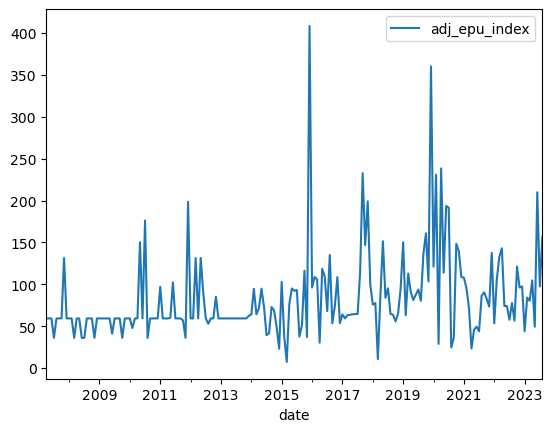

In [16]:
scaling_factor = 100/(stats[stats.date >= "2020-01-01"]["adj_z_score"].mean())
stats["adj_epu_index"] = stats["adj_z_score"] * scaling_factor
stats.plot(x="date", y="adj_epu_index");

In [ ]:
stats_alt = stats.copy()
stats_alt["news_count"] = stats_alt[["st_news_count", "ss_news_count", "tis_news_count", "sibc_news_count"]].mean(axis=1)
stats_alt["epu_count"] = stats_alt[["st_epu_count", "ss_epu_count", "tis_epu_count", "sibc_epu_count"]].mean(axis=1)
cutoff_index = stats_alt[stats_alt.date == pd.to_datetime("2019-12-01")].index[0] + 1
stats_alt["z_score_alt"] = get_epu_zscore(stats_alt, cutoff_index=cutoff_index)
sf_alt = 100/(stats_alt["z_score_alt"][cutoff_index:].mean())
stats_alt["epu_alt"] = sf_alt * stats_alt["z_score_alt"]
stats_alt.plot(x="date", y="epu_alt");